# Clasificación de suelos para propósitos de ingeniería
**Unified Soil Classification System - USCS**

© 2023 Daniel F. Ruiz, Exneyder A. Montoya-Araque y Universidad EAFIT.

Este notebook se puede ejecutar interactivamente en [Google - Colab](https://colab.research.google.com/github/AppliedMechanics-EAFIT/soil_mechanics/blob/main/notebooks/uscs_classification.ipynb).

Las rutinas de clasificación se basan en la norma [ASTM D2487 − 17𝜀1](https://www.astm.org/d2487-17.html)

## Required modules

In [1]:
if 'google.colab' in str(get_ipython()):
    from google.colab import files
else:
    import tkinter as tk
    from tkinter.filedialog import askopenfilename
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from ipywidgets import interact, widgets, fixed

## Global configuration for plots

In [2]:
plt.style.use("default")
mpl.rcParams.update(
    {
        "font.family": "serif",  # Use the Computer modern font
        "font.serif": "cmr10",
        "mathtext.fontset": "cm",
        "axes.formatter.use_mathtext": True,
        "axes.unicode_minus": False,
    }
)


# Reading the input data

In [3]:
if 'google.colab' in str(get_ipython()):
    file = files.upload()
    df = pd.read_excel(list(file.values())[0])
else:
    tk.Tk().withdraw() # part of the import if you are not using other tkinter functions
    file = askopenfilename()
    df = pd.read_excel(file)

# Tabulated input data

In [4]:
df

,Muestra,Profundidad_(m),Material,W_(%),LL_(%),LP_(%),IP_(%),Gravas_(%),Arenas_(%),Finos_(%),Cc,Cu
0,AP3-M3,"1,70 - 1,80",Deposito antropico,30.0,32.0,16.0,16.0,1.0,23.7,75.3,NaN,NaN
1,P1-M1,"0,00 – 0,50",Deposito antropico,43.4,45.0,24.0,21.0,0.0,3.7,96.3,NaN,NaN
2,P1-M3,"1,00 - 2,00",Deposito antropico,37.3,40.0,20.0,20.0,3.7,15.3,81.1,NaN,NaN
3,P2-M3,"1,00 - 1,55",Deposito antropico,21.5,23.0,20.0,3.0,12.3,41.4,46.3,NaN,NaN
4,P2-M7,"3,00 - 3,55",Deposito antropico,20.4,23.0,21.0,2.0,41.8,39.6,18.7,NaN,NaN
5,P2-M9,"4,00 - 4,55",Deposito antropico,13.8,NaN,NaN,NaN,10.9,52.6,36.5,NaN,NaN
6,P2-M14,"6,50 - 7,00",Deposito antropico,29.3,51.0,24.0,27.0,4.4,19.5,76.1,NaN,NaN
7,AP1-M2,"0,90 - 1,00",Deposito arcilloso,43.6,45.0,28.0,17.0,0.0,6.6,93.4,NaN,NaN
8,AP2-M4,"1,00 - 1,10",Deposito arcilloso,53.5,49.0,25.0,24.0,0.0,5.2,94.8,NaN,NaN
9,P1-M7,"4,00 – 5,10",Deposito arcilloso,36.7,54.0,24.0,30.0,0.0,1.1,98.9,NaN,NaN


## Funciones

In [5]:
def classify_fines(LL, IP):
    if np.isnan(LL) or np.isnan(IP):
        return '--'
    elif LL >= 50:
        return 'CH' if IP >= 0.73*(LL-20) else 'MH'
    elif IP >= 0.73*(LL-20) and IP > 7:
            return 'CL'
    elif IP >= 0.73*(LL-20) and IP >= 4:
            return 'CL-ML'
    else:
        return 'ML'


def classify_sands(G, S, F, LL, IP, Cc, Cu):
    fines = classify_fines(LL, IP)
    uscs = 'S-'
    if F <= 5:  # Clean sands
        uscs = "SW" if Cu >= 6 and Cc >= 1 and Cc <= 3 else "SP"
    elif F <= 12:  # Dirty(?) sands
        if Cu >= 6 and Cc >= 1 and Cc <= 3:
            if fines in ["ML", "MH"]:
                uscs = "SW-SM"
            elif fines in ["CL", "CH", "CL-ML"]:
                uscs = "SW-SC"
        else:
            if fines in ["ML", "MH"]:
                uscs = "SP-SM"
            elif fines in ["CL", "CH", "CL-ML"]:
                uscs = "SP-SC"
    else:  # Sands with Fines
        if fines in ["ML", "MH"]:
            uscs = "SM"
        elif fines in ["CL", "CH"]:
            uscs = "SC"
        elif fines == "CL-ML":
            uscs = "SC-SM"
    return uscs


def classify_gravels(G, S, F, LL, IP, Cc, Cu):
    fines = classify_fines(LL, IP)
    uscs = 'G?'
    if F <= 5:  # Clean gravels
        uscs = "GW" if Cu >= 4 and Cc >= 1 and Cc <= 3 else "GP"
    elif F <= 12:  # Dirty(?) gravels
        if Cu >= 4 and Cc >= 1 and Cc <= 3:
            if fines in ["ML", "MH"]:
                uscs = "GW-GM"
            elif fines in ["CL", "CH", "CL-ML"]:
                uscs = "GW-GC"
        else:
            if fines in ["ML", "MH"]:
                uscs = "GP-GM"
            elif fines in ["CL", "CH", "CL-ML"]:
                uscs = "GP-GC"
    else:  # Gravels with Fines
        if fines in ["ML", "MH"]:
            uscs = "GM"
        elif fines in ["CL", "CH"]:
            uscs = "GC"
        elif fines == "CL-ML":
            uscs = "GC-GM"
    return uscs


def classify_uscs(G, S, F, LL, IP, Cc, Cu):
    if G + S > 50 and G > S:  # Coarse-grained soils
        return classify_gravels(G, S, F, LL, IP, Cc, Cu)
    elif G + S > 50 and S > G:  # Sands
        return classify_sands(G, S, F, LL, IP, Cc, Cu)
    else:  # Fines
        return classify_fines(LL, IP)

def classify_table(df):
    fines, uscs= [], []
    for i in range(len(df)):
        row = df.iloc[i]
        fines.append(classify_fines(row['LL_(%)'], row['IP_(%)']))
        uscs.append(
            classify_uscs(row['Gravas_(%)'], row['Arenas_(%)'], row['Finos_(%)'],
                          row['LL_(%)'], row['IP_(%)'], row['Cc'], row['Cu']))
    df['Clasif_Finos'] = fines
    df['USCS'] = uscs
    return uscs


In [6]:
def plasticity_chart(df, figsize=None):
    figsize = [6.5, 5.5] if figsize is None else figsize
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=figsize)
    for material in df['Material'].unique():
        df_material = df[df.Material==material]
        ax.plot(df_material['LL_(%)'], df_material['IP_(%)'], ls='', marker='o',
                fillstyle='none', mew=1.5, label=material)
    ### Casagrande Chart plot
    ax.plot([0, 25.5, 999], [4, 4, 0.73*(999-20)], 'k') # A-line
    ax.plot([16, 16, 999], [0, 7, 0.9*(999-8)], ':k') # U-line
    ax.plot([0, 4/0.73+20, 7/0.73+20, 0], [4, 4, 7, 7], 'k') # CL-ML
    ax.axvline(x=50, color='k') # B-line
    # labels
    ax.text(40, 22.5, 'CL', ha='center', va='center')
    ax.text(70, 45, 'CH', ha='center', va='center')
    ax.text(70, 15, 'MH', ha='center', va='center')
    ax.text(40, 5, 'ML', ha='center', va='center')
    ax.text(20, 5.2, 'CL-ML', ha='center', va='center')
    # Format
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid(True, ls="--", lw=0.5)
    # ax.set_aspect("equal", anchor=None)
    ax.set(xlabel='LL [%]', ylabel='IP [%]')
    ax.set_xlim(0, np.max((100, df['LL_(%)'].max()+10)))
    ax.set_ylim(0, np.max((60, df['IP_(%)'].max()+10)))
    ax.spines["bottom"].set_linewidth(1.5)
    ax.spines["left"].set_linewidth(1.5)
    fig.tight_layout()
    return

# Visualizing the plasticity chart

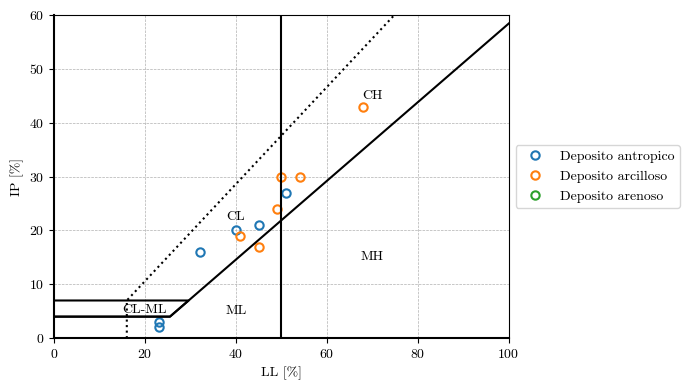

In [11]:
plasticity_chart(df, figsize=[7,4])

# Classifying the input data

In [8]:
classify_table(df)
df

,Muestra,Profundidad_(m),Material,W_(%),LL_(%),LP_(%),IP_(%),Gravas_(%),Arenas_(%),Finos_(%),Cc,Cu,Clasif_Finos,USCS
0,AP3-M3,"1,70 - 1,80",Deposito antropico,30.0,32.0,16.0,16.0,1.0,23.7,75.3,NaN,NaN,CL,CL
1,P1-M1,"0,00 – 0,50",Deposito antropico,43.4,45.0,24.0,21.0,0.0,3.7,96.3,NaN,NaN,CL,CL
2,P1-M3,"1,00 - 2,00",Deposito antropico,37.3,40.0,20.0,20.0,3.7,15.3,81.1,NaN,NaN,CL,CL
3,P2-M3,"1,00 - 1,55",Deposito antropico,21.5,23.0,20.0,3.0,12.3,41.4,46.3,NaN,NaN,ML,SM
4,P2-M7,"3,00 - 3,55",Deposito antropico,20.4,23.0,21.0,2.0,41.8,39.6,18.7,NaN,NaN,ML,GM
5,P2-M9,"4,00 - 4,55",Deposito antropico,13.8,NaN,NaN,NaN,10.9,52.6,36.5,NaN,NaN,--,S-
6,P2-M14,"6,50 - 7,00",Deposito antropico,29.3,51.0,24.0,27.0,4.4,19.5,76.1,NaN,NaN,CH,CH
7,AP1-M2,"0,90 - 1,00",Deposito arcilloso,43.6,45.0,28.0,17.0,0.0,6.6,93.4,NaN,NaN,ML,ML
8,AP2-M4,"1,00 - 1,10",Deposito arcilloso,53.5,49.0,25.0,24.0,0.0,5.2,94.8,NaN,NaN,CL,CL
9,P1-M7,"4,00 – 5,10",Deposito arcilloso,36.7,54.0,24.0,30.0,0.0,1.1,98.9,NaN,NaN,CH,CH
